In [1]:
import numpy as np
import pickle
import pynbody
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt
import pylab

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
custom_blues = ["#99DDFF","#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466", "#000000"]
custom_bluegreens = ["#99FFDD","#66FFCC", "#33FFBB", "#00FFAA", "#00CC88", "#009966", "#006644", "#000000"]
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]
custom_cet_fdm = ["#EE99FF","#E566FF","#DD33FF","#D400FF","#AA00CC","#7F0099","#550066"]

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['wdm_3'] = custom_blues_complement[1]
sim_colors['wdm_4'] = custom_blues_complement[2]
sim_colors['wdm_5'] = custom_blues_complement[3]
sim_colors['wdm_6'] = custom_blues_complement[4]
sim_colors['wdm_6.5'] = custom_blues_complement[5]
sim_colors['wdm_10'] = custom_blues_complement[6]
sim_colors['idm_n2_1e-4GeV'] = custom_blues[2]
sim_colors['idm_n2_1e-2GeV'] = custom_blues[4]
sim_colors['idm_n2_1GeV'] = custom_blues[6]
sim_colors['idm_n4_1e-4GeV'] = custom_bluegreens[2]
sim_colors['idm_n4_1e-2GeV'] = custom_bluegreens[4]
sim_colors['idm_n4_1GeV'] = custom_bluegreens[6]
sim_colors['fdm_25.9e-22eV'] = custom_cet_fdm[1]
sim_colors['fdm_69.4e-22eV'] = custom_cet_fdm[2]
sim_colors['fdm_113e-22eV'] = custom_cet_fdm[3]
sim_colors['fdm_151e-22eV'] = custom_cet_fdm[4]
sim_colors['fdm_185e-22eV'] = custom_cet_fdm[5]
sim_colors['fdm_490e-22eV'] = custom_cet_fdm[6]
sim_colors['running_10'] = 'teal'
sim_colors['running_1'] = 'goldenrod'

plt.rc("text", usetex=True)
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams["xtick.major.size"]  = 8
plt.rcParams["xtick.minor.size"]  = 3
plt.rcParams["ytick.major.size"]  = 8
plt.rcParams["ytick.minor.size"]  = 3
plt.rcParams["xtick.direction"]  = "out"
plt.rcParams["ytick.direction"]  = "out"
plt.rcParams["legend.frameon"] = 'False'

In [2]:
import colossus
from colossus.halo import profile_nfw
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 70.0, 'Om0': 0.286, 'Ob0': 0.049, 'sigma8': 0.82, 'ns': 0.96}
cosmology.addCosmology('myCosmo', **params)
cosmo = cosmology.setCosmology('myCosmo')

In [3]:
h = 0.7
Omega_m = 0.286
rho_m = cosmo.rho_m(0.)*1e9*(0.7**2) #Msun/Mpc^3

def M_k(k):
    return 4*np.pi*rho_m*((np.pi/k)**3)/3.

def k_M(M):
    return (3.*M/(4*np.pi*rho_m))**(-1./3.)*np.pi

Processing Reference...
Processing My Data...
  Found: idm_run_n2_m1ep00_s1.6e-23_halfmode00_pk.dat
Done.


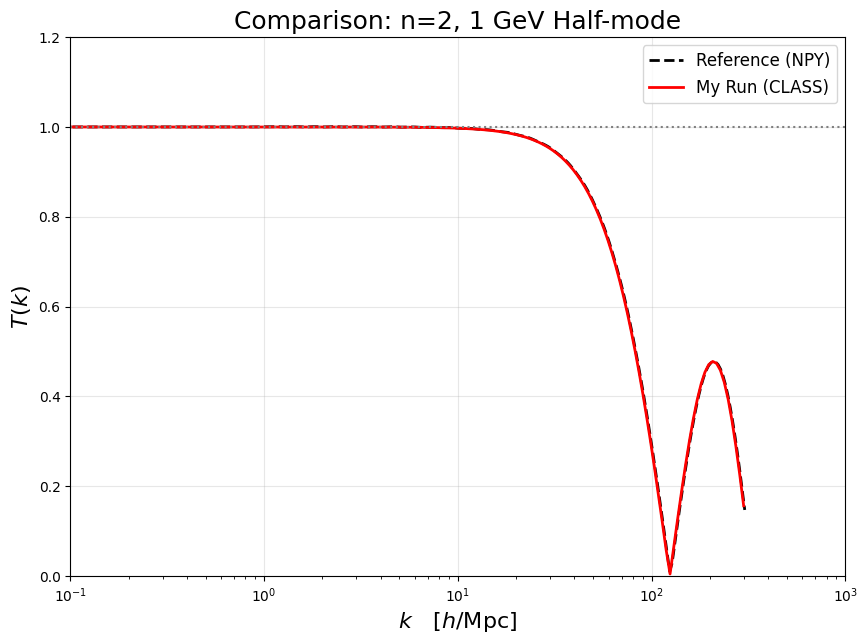

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# --- Configuration ---
BASE_DIR = "/home/arifchu/"
# Update these paths if your directories are named differently
MY_DATA_DIR = os.path.join(BASE_DIR, "class_public-master-new-dmeff/COZMIC_test_output/")
REF_DATA_DIR = os.path.join(BASE_DIR, "COZMIC_IDM_Tk/")

# Reference Filenames
REF_FILE_K   = "halfmode_k_idm_1GeV_n2.npy"
REF_FILE_CDM = "halfmode_cdm_1GeV_n2.npy"
REF_FILE_IDM = "halfmode_idm_1GeV_n2.npy"

# My Data Pattern
MY_FILE_PATTERN = "idm_run_n2_m1ep00_*halfmode*_pk.dat"

# --- Helper Functions ---

def load_npy_robust(path):
    if not os.path.exists(path): return None
    try: return np.load(path)
    except: return None

def process_reference_data(k_path, cdm_path, idm_path):
    arr_k = load_npy_robust(k_path)
    arr_cdm = load_npy_robust(cdm_path)
    arr_idm = load_npy_robust(idm_path)

    if arr_cdm is None or arr_idm is None:
        print("  Reference CDM or IDM file missing.")
        return None, None

    # Smart extraction
    def extract_kp(arr, fallback_k):
        if arr.ndim == 2 and arr.shape[1] >= 2:
            return arr[:, 0], arr[:, 1]
        return fallback_k, arr

    k_cdm, p_cdm = extract_kp(arr_cdm, arr_k)
    k_idm, p_idm = extract_kp(arr_idm, k_cdm if k_cdm is not None else arr_k)

    if k_idm is None:
        print("  Could not determine k-vector for Reference.")
        return None, None

    # Interpolate CDM to IDM grid if needed
    if k_cdm is not None and len(k_cdm) != len(k_idm):
        p_cdm = np.interp(k_idm, k_cdm, p_cdm)
    elif k_cdm is not None and np.any(k_cdm != k_idm): # Same length but diff values
        p_cdm = np.interp(k_idm, k_cdm, p_cdm)
        
    # Calculate Ratio
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.sqrt(p_idm / p_cdm)
        
    return k_idm, ratio

def load_class_pk(path):
    if not os.path.exists(path): return None, None
    try:
        d = np.loadtxt(path)
        return d[:, 0], d[:, 1]
    except: return None, None

# --- Main Execution ---

# 1. Reference
print("Processing Reference...")
k_ref, t_ref = process_reference_data(
    os.path.join(REF_DATA_DIR, REF_FILE_K),
    os.path.join(REF_DATA_DIR, REF_FILE_CDM),
    os.path.join(REF_DATA_DIR, REF_FILE_IDM)
)

# 2. My Data
print("Processing My Data...")
search = os.path.join(MY_DATA_DIR, MY_FILE_PATTERN)
files = glob.glob(search)
k_mine, t_mine = None, None

if files:
    my_file = files[0]
    print(f"  Found: {os.path.basename(my_file)}")
    
    # Check if it's Tk or Pk
    if "tk.dat" in my_file:
        data = np.loadtxt(my_file)
        k_mine = data[:, 0]
        t_mine = data[:, 6] # T_total usually
    else:
        k_idm, p_idm = load_class_pk(my_file)
        
        # Look for local CDM to normalize
        cdm_search = os.path.join(MY_DATA_DIR, "*cdm*pk.dat")
        cdm_files = glob.glob(cdm_search)
        if cdm_files:
            k_c, p_c = load_class_pk(cdm_files[0])
            p_c_interp = np.interp(k_idm, k_c, p_c)
            t_mine = np.sqrt(p_idm / p_c_interp)
            k_mine = k_idm
        else:
            print("  Warning: No local CDM baseline found. Plotting raw sqrt(P).")
            t_mine = np.sqrt(p_idm)
            k_mine = k_idm

# 3. Plot
plt.figure(figsize=(10, 7))

if k_ref is not None:
    plt.semilogx(k_ref, t_ref, 'k--', linewidth=2, label='Reference (NPY)')

if k_mine is not None:
    plt.semilogx(k_mine, t_mine, 'r-', linewidth=2, label='My Run (CLASS)')

plt.axhline(1.0, color='gray', ls=':')
plt.xlabel(r'$k \quad [h/\mathrm{Mpc}]$', fontsize=16)
plt.ylabel(r'$T(k)$', fontsize=16)
plt.title(r'Comparison: n=2, 1 GeV Half-mode', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0.1, 1000) # Request for k=1000
plt.ylim(0.0, 1.2)

plt.savefig("comparison_n2_1GeV_halfmode_robust.png", dpi=150)
print("Done.")
plt.show()

In [4]:
from scipy.interpolate import griddata

BASE_PATH = '/home/arifchu/class_public-master-new-dmeff/pks/'
BASE_PATH_ALT = '/central/groups/carnegie_poc/enadler/ncdm_resims/Halo004/running_v1/'

cdm = np.loadtxt(BASE_PATH+'lcdm_pk.dat')
cdm_z99 = np.loadtxt('/home/arifchu/class_public-master-new-dmeff/lcdm_class_z99_sync_pk.dat')

wdm_transfers = {}
cdm_transfers_wdm = {}
for mass in ['3', '3.5', '4', '5', '6','6.5', '10']:
    if mass in ['6','6.5']:
        wdm_transfers[mass] = np.loadtxt(BASE_PATH+'wdm_{}KeV_pk.dat'.format(mass))
        print(mass)
        kpeak = np.array(wdm_transfers[mass][:,0])[np.argmax(wdm_transfers[mass][:,1]*wdm_transfers[mass][:,0]**3*0.7)]
        print(kpeak)
        print(10.1*rho_m*(22./1000.)*(kpeak**-2)/1e8)
    else:
        wdm_transfers[mass] = np.loadtxt(BASE_PATH+'wdm_{}kev_pk.dat'.format(mass))
        print(mass)
        kpeak = np.array(wdm_transfers[mass][:,0])[np.argmax(wdm_transfers[mass][:,1]*wdm_transfers[mass][:,0]**3*0.7)]
        print(kpeak)
        print(10.1*rho_m*(22./1000.)*(kpeak**-2)/1e8)
    cdm_transfers_wdm[mass] = griddata(cdm[:,0], cdm[:,1], wdm_transfers[mass][:,0], method='cubic')
        
print('\n')

fdm_transfers = {}
cdm_transfers_fdm = {}
for mass in ['25.9', '69.4', '113', '151', '185', '490']:
    fdm_transfers[mass] = np.loadtxt(BASE_PATH+'fdm_{}e-22eV_pk.dat'.format(mass))
    print(mass)
    kpeak = np.array(fdm_transfers[mass][:,0])[np.argmax(fdm_transfers[mass][:,1]*fdm_transfers[mass][:,0]**3*0.7)]
    print(kpeak)
    print(10.1*rho_m*(22./1000.)*(kpeak**-2)/1e8)
    cdm_transfers_fdm[mass] = griddata(cdm[:,0], cdm_z99[:,1], fdm_transfers[mass][:,0], method='cubic')

print('\n')

idm_transfers = {}
cdm_transfers_idm = {}
for n in ['2','4']:
    idm_transfers[n] = {}
    cdm_transfers_idm[n] = {}
    for mass in ['1e-4GeV', '1e-2GeV', '1GeV']:
        idm_transfers[n][mass] = {}
        cdm_transfers_idm[n][mass] = {}
        for method in ['halfmode', 'envelope']:
            if n == '2':
                idm_transfers[n][mass][method] = np.loadtxt(BASE_PATH+'idm_n{}_{}_{}_z0_Pk.dat'.format(n,mass,method))
                print(n,mass,method)
                kpeak = np.array(idm_transfers[n][mass][method][:,0])[np.argmax(idm_transfers[n][mass][method][:,1]*idm_transfers[n][mass][method][:,0]**3*0.7)]
                print(kpeak)
                print(10.1*rho_m*(22./1000.)*(kpeak**-2)/1e8)
            else:
                print(n,mass,method)
                idm_transfers[n][mass][method] = np.loadtxt(BASE_PATH+'idm_{}_{}_pk.dat'.format(mass,method))
                kpeak = np.array(idm_transfers[n][mass][method][:,0])[np.argmax(idm_transfers[n][mass][method][:,1]*idm_transfers[n][mass][method][:,0]**3*0.7)]
                print(kpeak)
                print(10.1*rho_m*(22./1000.)*(kpeak**-2)/1e8)
            cdm_transfers_idm[n][mass][method] = griddata(cdm[:,0], cdm[:,1], 
                                                      idm_transfers[n][mass][method][:,0], method='cubic')
    print('\n')

3
12.71544306778
0.5345194078185646
3.5
12.71544306685
0.5345194078967535
4
16.00779439835
0.3372589462103964
5
20.15261915389
0.21279600912356672


FileNotFoundError: /home/arifchu/class_public-master-new-dmeff/pks/wdm_6kev_pk.dat not found.

In [ ]:
wdm_transfers['6.5']

In [ ]:
np.save('6.5_cdm_transfer.npy', cdm_transfers_wdm['6.5'])

In [ ]:
np.save('6.5_wdm_transfer.npy', wdm_transfers['6.5'])

In [ ]:
np.save('3_wdm_transfer.npy', cdm_transfers_wdm['3'])

In [ ]:
np.save('3_wdm_transfer.npy', wdm_transfers['3'])

In [ ]:
np.save('4_wdm_transfer.npy', cdm_transfers_wdm['4'])

In [ ]:
np.save('4_wdm_transfer.npy', wdm_transfers['4'])

In [ ]:
np.save('5_wdm_transfer.npy', cdm_transfers_wdm['5'])

In [ ]:
np.save('5_wdm_transfer.npy', wdm_transfers['5'])

In [ ]:
np.save('6_wdm_transfer.npy', cdm_transfers_wdm['6'])

In [ ]:
np.save('6_wdm_transfer.npy', wdm_transfers['6'])

In [ ]:
np.save('6.5_wdm_transfer.npy', cdm_transfers_wdm['6.5'])

In [ ]:
np.save('6.5_wdm_transfer.npy', wdm_transfers['6.5'])

In [ ]:
np.save('10_wdm_transfer.npy', cdm_transfers_wdm['10'])

In [ ]:
np.save('10_wdm_transfer.npy', wdm_transfers['10'])

NameError: name 'wdm_transfers' is not defined

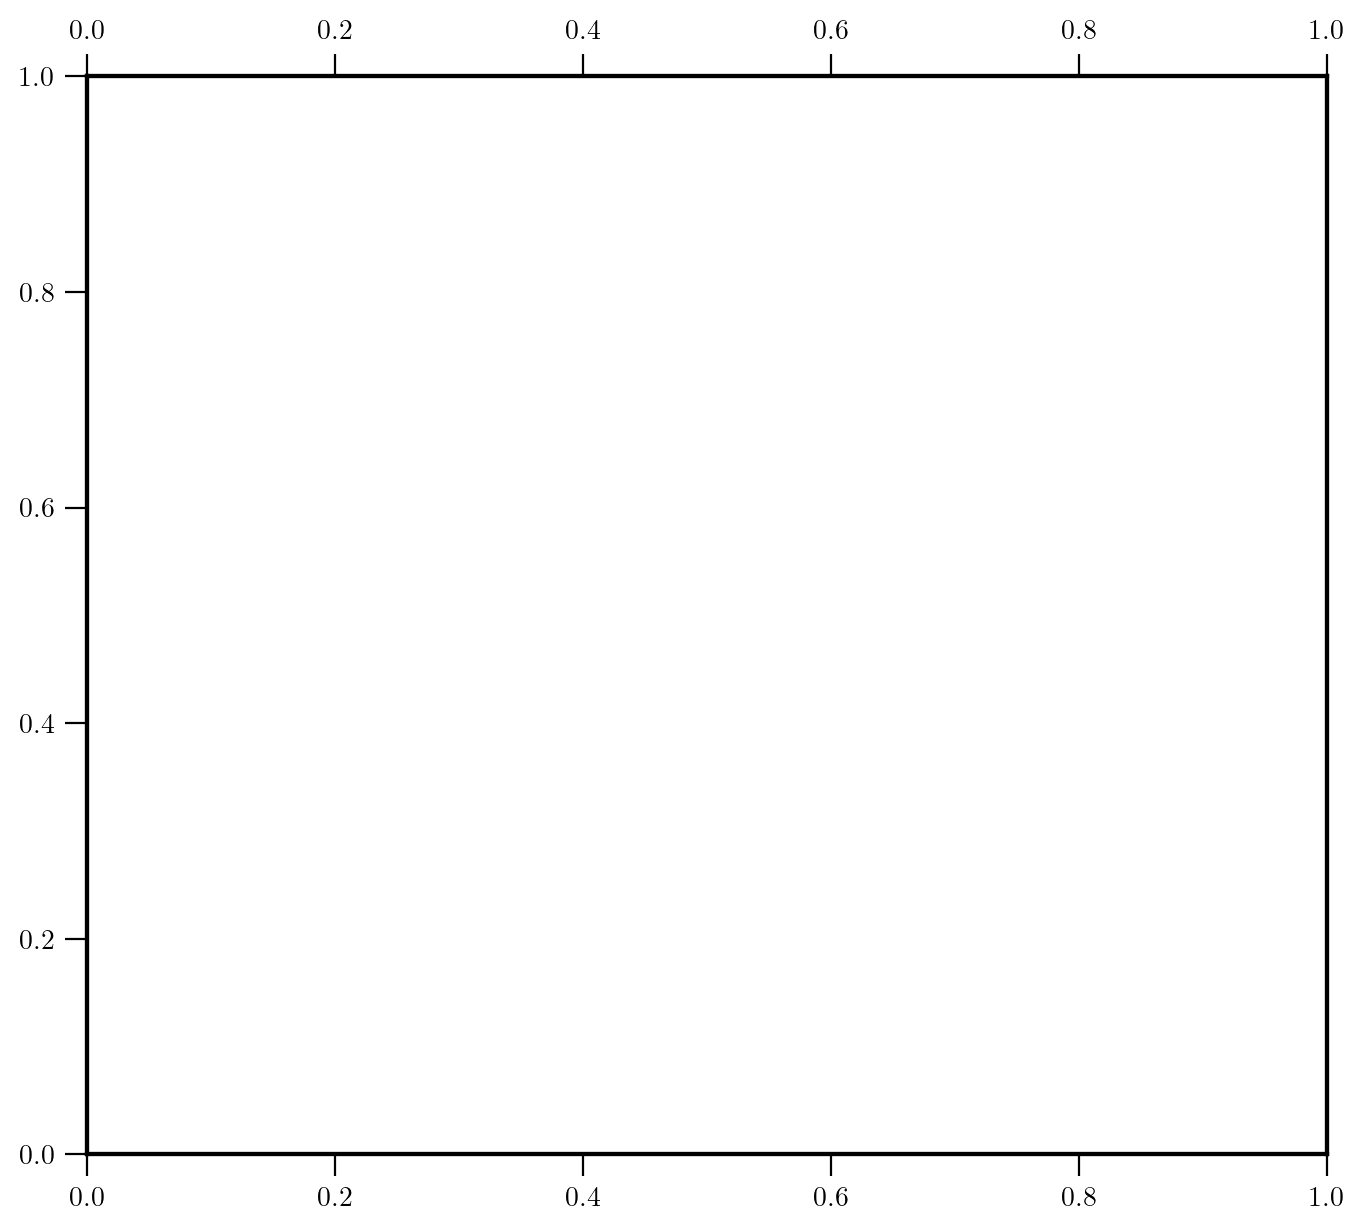

In [2]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

labels_wdm = {'3': r'$m_{\mathrm{WDM}}=3\ \mathrm{keV}$', '4': r'$m_{\mathrm{WDM}}=4\ \mathrm{keV}$',
         '5': r'$m_{\mathrm{WDM}}=5\ \mathrm{keV}$', '6': r'$m_{\mathrm{WDM}}=6\ \mathrm{keV}$',
         '6.5': r'$m_{\mathrm{WDM}}=6.5\ \mathrm{keV}$', '10': r'$m_{\mathrm{WDM}}=10\ \mathrm{keV}$'}

for mass in ['3', '4', '5', '6','6.5', '10']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    print(mass)
    print((wdm_transfers[mass][:,0][ind]*0.7)[np.argmax(wdm_transfers[mass][:,0][ind]**3*wdm_transfers[mass][:,1][ind])])
    print((wdm_transfers[mass][:,0][ind]*0.7)[np.argmin(np.abs((wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind]-0.25))])
    print(13.93*(wdm_transfers[mass][:,0]*0.7)[np.argmin(np.abs((wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind]-0.25))])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],
             label=labels_wdm[mass])

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{WDM}}(k) = P_{\mathrm{WDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
ax.legend(loc=3,fontsize=16,frameon=False)

# ax.set_title(r'$\mathrm{Warm\ Dark\ Matter}$',fontsize=25)
#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/transfer_wdm.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

labels_fdm = {'25.9': r'$m_{\mathrm{FDM},22}=25.9$', '69.4': r'$m_{\mathrm{FDM},22}=69.4$',
         '113': r'$m_{\mathrm{FDM},22}=113$', '151': r'$m_{\mathrm{FDM},22}=151$',
         '185': r'$m_{\mathrm{FDM},22}=185$', '490': r'$m_{\mathrm{FDM},22}=490$'}

for mass in ['3', '4', '5', '6','6.5', '10']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)
    
for mass in ['25.9','69.4','113','151','185','490']:
    ind = ~np.isnan(fdm_transfers[mass][:,1]/cdm_transfers_fdm[mass])
    print(mass)
    print((fdm_transfers[mass][:,0][ind]*0.7)[np.argmax(fdm_transfers[mass][:,0][ind]**3*fdm_transfers[mass][:,1][ind])])
    print((fdm_transfers[mass][:,0][ind]*0.7)[np.argmin(np.abs((fdm_transfers[mass][:,1]/cdm_transfers_fdm[mass])[ind]-0.25))])
    print((9.*np.sqrt(float(mass))))
    print(1.92/float(mass))
    print('\n')
    ax.semilogx(fdm_transfers[mass][:,0][ind]*0.7,(fdm_transfers[mass][:,1]/cdm_transfers_fdm[mass])[ind],
                 lw=2,c=sim_colors['fdm_{}e-22eV'.format(mass)],
             label=labels_fdm[mass])

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{FDM}}(k) = P_{\mathrm{FDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
ax.legend(loc=3,fontsize=16,frameon=False)

# ax.set_title(r'$\mathrm{Warm\ Dark\ Matter}$',fontsize=25)
#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/transfer_fdm.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)
    
m4 = ax.semilogx(idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')

halfmode = ax.semilogx(idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{half}$-$\mathrm{mode}$')

print('2','1e-4GeV','halfmode')
print((idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['2']['1e-4GeV']['halfmode'][:,0]**3*idm_transfers['2']['1e-4GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode'])-0.25))
k_short = idm_transfers['2']['1e-4GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode'])[minimum_ind:]
print((idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7)[halfmode_ind])
print(k_short[24])
print(idm_transfer_short[24])
print('\n')

envelope = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{envelope}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('2','1e-4GeV','envelope')
print((idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['2']['1e-4GeV']['envelope'][:,0]**3*idm_transfers['2']['1e-4GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope'])-0.01))
k_short = idm_transfers['2']['1e-4GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope'])[minimum_ind:]
print((idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7)[halfmode_ind])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

m2 = ax.semilogx(idm_transfers['2']['1e-2GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')

print('2','1e-2GeV','halfmode')
print((idm_transfers['2']['1e-2GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['2']['1e-2GeV']['halfmode'][:,0]**3*idm_transfers['2']['1e-2GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['halfmode'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['halfmode'])-0.1))
k_short = idm_transfers['2']['1e-2GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['halfmode'])[minimum_ind:]
print((idm_transfers['2']['1e-2GeV']['halfmode'][:,0]*0.7)[halfmode_ind])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.semilogx(idm_transfers['2']['1e-2GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_n2_1e-2GeV'])#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('2','1e-2GeV','envelope')
print((idm_transfers['2']['1e-2GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['2']['1e-2GeV']['envelope'][:,0]**3*idm_transfers['2']['1e-2GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['envelope'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['envelope'])-0.1))
k_short = idm_transfers['2']['1e-2GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['envelope'])[minimum_ind:]
print((idm_transfers['2']['1e-2GeV']['envelope'][:,0]*0.7)[halfmode_ind])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

m0 = ax.semilogx(idm_transfers['2']['1GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1GeV'],label='$m_{\mathrm{DM}}=10^{0}\ \mathrm{GeV}$')

print('2','1GeV','halfmode')
print((idm_transfers['2']['1GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['2']['1GeV']['halfmode'][:,0]**3*idm_transfers['2']['1GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1GeV']['halfmode'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1GeV']['halfmode'])-0.1))
k_short = idm_transfers['2']['1GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1GeV']['halfmode'])[minimum_ind:]
print((idm_transfers['2']['1GeV']['halfmode'][:,0]*0.7)[halfmode_ind])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.semilogx(idm_transfers['2']['1GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_n2_1GeV'])#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('2','1GeV','envelope')
print((idm_transfers['2']['1GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['2']['1GeV']['envelope'][:,0]**3*idm_transfers['2']['1GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1GeV']['envelope'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1GeV']['envelope'])-0.1))
k_short = idm_transfers['2']['1GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1GeV']['envelope'])[minimum_ind:]
print((idm_transfers['2']['1GeV']['envelope'][:,0]*0.7)[halfmode_ind])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[halfmode[0],envelope[0]], loc=1, fontsize=16, frameon=False, bbox_to_anchor = (1.0,0.95))
ax.text(1.25,0.35,r'$n=2$',fontsize=24)

#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/transfer_idm_n2.pdf')
plt.show()

In [ ]:
import numpy as np

# Load IDM halfmode transfer functions
halfmode_1e4 = idm_transfers['2']['1e-4GeV']['halfmode']
halfmode_1e2 = idm_transfers['2']['1e-2GeV']['halfmode']
halfmode_1e0 = idm_transfers['2']['1GeV']['halfmode']

# Load IDM envelope transfer functions
envelope_1e4 = idm_transfers['2']['1e-4GeV']['envelope']
envelope_1e2 = idm_transfers['2']['1e-2GeV']['envelope']
envelope_1e0 = idm_transfers['2']['1GeV']['envelope']

# Load CDM reference transfer functions for each case
T_cdm_1e4 = cdm_transfers_idm['2']['1e-4GeV']['halfmode']
T_cdm_1e2 = cdm_transfers_idm['2']['1e-2GeV']['halfmode']
T_cdm_1e0 = cdm_transfers_idm['2']['1GeV']['halfmode']

# Extract k and T for IDM
k_vals = halfmode_1e4[:, 0]
T_idm_half_1e4 = halfmode_1e4[:, 1]
T_idm_half_1e2 = halfmode_1e2[:, 1]
T_idm_half_1e0 = halfmode_1e0[:, 1]

T_idm_env_1e4 = envelope_1e4[:, 1]
T_idm_env_1e2 = envelope_1e2[:, 1]
T_idm_env_1e0 = envelope_1e0[:, 1]

# Compute ratios (IDM / CDM)
R_half_1e4 = T_idm_half_1e4 / T_cdm_1e4
R_half_1e2 = T_idm_half_1e2 / T_cdm_1e2
R_half_1e0 = T_idm_half_1e0 / T_cdm_1e0

R_env_1e4 = T_idm_env_1e4 / T_cdm_1e4
R_env_1e2 = T_idm_env_1e2 / T_cdm_1e2
R_env_1e0 = T_idm_env_1e0 / T_cdm_1e0

# Stack all into one array: k, halfmode_ratios, envelope_ratios
data_to_save = np.column_stack((
    k_vals,
    R_half_1e4, R_half_1e2, R_half_1e0,
    R_env_1e4, R_env_1e2, R_env_1e0
))

# Save to file
np.savetxt("idm_cdm_transfer_ratios_halfmode_envelope_n2.dat", data_to_save,
           header="k [1/Mpc]   R_half_1e-4GeV   R_half_1e-2GeV   R_half_1GeV   R_env_1e-4GeV   R_env_1e-2GeV   R_env_1GeV",
           fmt="%.6e", delimiter="\t")

print("Saved: idm_cdm_transfer_ratios_halfmode_envelope_n2.dat")


In [ ]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)
    
m4 = ax.semilogx(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n4_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')

print('4','1e-4GeV','halfmode')
print((idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]**3*idm_transfers['4']['1e-4GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode'])-0.25))
k_short = idm_transfers['4']['1e-4GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode'])[minimum_ind:]
print((idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7)[halfmode_ind])
print(k_short[46])
print(idm_transfer_short[46])
print('\n')

halfmode = ax.semilogx(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7,
             -1.*(idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n4_1e-4GeV'],label='$\mathrm{half}$-$\mathrm{mode}$')

envelope = ax.semilogx(idm_transfers['4']['1e-4GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_n4_1e-4GeV'],label='$\mathrm{envelope}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('4','1e-4GeV','envelope')
print((idm_transfers['4']['1e-4GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['4']['1e-4GeV']['envelope'][:,0]**3*idm_transfers['4']['1e-4GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['envelope'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['envelope'])-0.25))
k_short = idm_transfers['4']['1e-4GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['envelope'])[minimum_ind:]
print((idm_transfers['4']['1e-4GeV']['envelope'][:,0]*0.7)[halfmode_ind])
print(k_short[65])
print(idm_transfer_short[65])
print('\n')

m2 = ax.semilogx(idm_transfers['4']['1e-2GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n4_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')

print('4','1e-2GeV','halfmode')
print((idm_transfers['4']['1e-2GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['4']['1e-2GeV']['halfmode'][:,0]**3*idm_transfers['4']['1e-2GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode'])-0.9))
k_short = idm_transfers['4']['1e-2GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode'])[minimum_ind:]
print(k_short[50])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.semilogx(idm_transfers['4']['1e-2GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_n4_1e-2GeV'])#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('4','1e-2GeV','envelope')
print((idm_transfers['4']['1e-2GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['4']['1e-2GeV']['envelope'][:,0]**3*idm_transfers['4']['1e-2GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope'])-0.9))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope'])-0.35))
k_short = idm_transfers['4']['1e-2GeV']['envelope'][:,0][halfmode_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope'])[halfmode_ind:]
print(k_short[50])
k_short = idm_transfers['4']['1e-2GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope'])[minimum_ind:]
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

m0 = ax.semilogx(idm_transfers['4']['1GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n4_1GeV'],label='$m_{\mathrm{DM}}=10^{0}\ \mathrm{GeV}$')

print('4','1GeV','halfmode')
print((idm_transfers['4']['1GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['4']['1GeV']['halfmode'][:,0]**3*idm_transfers['4']['1GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])-0.9))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])-0.1))
k_short = idm_transfers['4']['1GeV']['envelope'][:,0][halfmode_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])[halfmode_ind:]
print(k_short[55])
k_short = idm_transfers['4']['1GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])[minimum_ind:]
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.semilogx(idm_transfers['4']['1GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_n4_1GeV'])#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('4','1GeV','envelope')
print((idm_transfers['4']['1GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['4']['1GeV']['envelope'][:,0]**3*idm_transfers['4']['1GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope'])-0.9))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope'])-0.1))
k_short = idm_transfers['4']['1GeV']['envelope'][:,0][halfmode_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope'])[halfmode_ind:]
print(k_short[55])
k_short = idm_transfers['4']['1GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope'])[minimum_ind:]
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[halfmode[0],envelope[0]], loc=1, fontsize=16, frameon=False, bbox_to_anchor = (1.0,0.95))
ax.text(1.25,0.35,r'$n=4$',fontsize=24)

#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/transfer_idm_n4.pdf')
plt.show()

In [ ]:
# n=2 Models
# ------------------------------------------------------------------------------------------------------
# m_DM = 1e-4 GeV (idm_transfers['2']['1e-4GeV'])
np.save('halfmode_idm_1e-4_n2.npy', idm_transfers['2']['1e-4GeV']['halfmode'])
np.save('envelope_idm_1e-4_n2.npy', idm_transfers['2']['1e-4GeV']['envelope'])
np.save('halfmode_k_idm_1e-4_n2.npy', idm_transfers['2']['1e-4GeV']['halfmode'][:,0])
np.save('envelope_k_idm_1e-4_n2.npy', idm_transfers['2']['1e-4GeV']['envelope'][:,0])
np.save('halfmode_cdm_1e-4_n2.npy', cdm_transfers_idm['2']['1e-4GeV']['halfmode'])
np.save('envelope_cdm_1e-4_n2.npy', cdm_transfers_idm['2']['1e-4GeV']['envelope'])

# m_DM = 1e-2 GeV (idm_transfers['2']['1e-2GeV'])
np.save('halfmode_idm_1e-2_n2.npy', idm_transfers['2']['1e-2GeV']['halfmode'])
np.save('envelope_idm_1e-2_n2.npy', idm_transfers['2']['1e-2GeV']['envelope'])
np.save('halfmode_k_idm_1e-2_n2.npy', idm_transfers['2']['1e-2GeV']['halfmode'][:,0])
np.save('envelope_k_idm_1e-2_n2.npy', idm_transfers['2']['1e-2GeV']['envelope'][:,0])
np.save('halfmode_cdm_1e-2_n2.npy', cdm_transfers_idm['2']['1e-2GeV']['halfmode'])
np.save('envelope_cdm_1e-2_n2.npy', cdm_transfers_idm['2']['1e-2GeV']['envelope'])

# m_DM = 1 GeV (idm_transfers['2']['1GeV'])
np.save('halfmode_idm_1GeV_n2.npy', idm_transfers['2']['1GeV']['halfmode'])
np.save('envelope_idm_1GeV_n2.npy', idm_transfers['2']['1GeV']['envelope'])
np.save('halfmode_k_idm_1GeV_n2.npy', idm_transfers['2']['1GeV']['halfmode'][:,0])
np.save('envelope_k_idm_1GeV_n2.npy', idm_transfers['2']['1GeV']['envelope'][:,0])
np.save('halfmode_cdm_1GeV_n2.npy', cdm_transfers_idm['2']['1GeV']['halfmode'])
np.save('envelope_cdm_1GeV_n2.npy', cdm_transfers_idm['2']['1GeV']['envelope'])
# ------------------------------------------------------------------------------------------------------

# n=4 Models
# ------------------------------------------------------------------------------------------------------
# m_DM = 1e-4 GeV (idm_transfers['4']['1e-4GeV'])
np.save('halfmode_idm_1e-4_n4.npy', idm_transfers['4']['1e-4GeV']['halfmode'])
np.save('envelope_idm_1e-4_n4.npy', idm_transfers['4']['1e-4GeV']['envelope'])
np.save('halfmode_k_idm_1e-4_n4.npy', idm_transfers['4']['1e-4GeV']['halfmode'][:,0])
np.save('envelope_k_idm_1e-4_n4.npy', idm_transfers['4']['1e-4GeV']['envelope'][:,0])
np.save('halfmode_cdm_1e-4_n4.npy', cdm_transfers_idm['4']['1e-4GeV']['halfmode'])
np.save('envelope_cdm_1e-4_n4.npy', cdm_transfers_idm['4']['1e-4GeV']['envelope'])

# m_DM = 1e-2 GeV (idm_transfers['4']['1e-2GeV'])
np.save('halfmode_idm_1e-2_n4.npy', idm_transfers['4']['1e-2GeV']['halfmode'])
np.save('envelope_idm_1e-2_n4.npy', idm_transfers['4']['1e-2GeV']['envelope'])
np.save('halfmode_k_idm_1e-2_n4.npy', idm_transfers['4']['1e-2GeV']['halfmode'][:,0])
np.save('envelope_k_idm_1e-2_n4.npy', idm_transfers['4']['1e-2GeV']['envelope'][:,0])
np.save('halfmode_cdm_1e-2_n4.npy', cdm_transfers_idm['4']['1e-2GeV']['halfmode'])
np.save('envelope_cdm_1e-2_n4.npy', cdm_transfers_idm['4']['1e-2GeV']['envelope'])

# m_DM = 1 GeV (idm_transfers['4']['1GeV'])
np.save('halfmode_idm_1GeV_n4.npy', idm_transfers['4']['1GeV']['halfmode'])
np.save('envelope_idm_1GeV_n4.npy', idm_transfers['4']['1GeV']['envelope'])
np.save('halfmode_k_idm_1GeV_n4.npy', idm_transfers['4']['1GeV']['halfmode'][:,0])
np.save('envelope_k_idm_1GeV_n4.npy', idm_transfers['4']['1GeV']['envelope'][:,0])
np.save('halfmode_cdm_1GeV_n4.npy', cdm_transfers_idm['4']['1GeV']['halfmode'])
np.save('envelope_cdm_1GeV_n4.npy', cdm_transfers_idm['4']['1GeV']['envelope'])
# ------------------------------------------------------------------------------------------------------

In [ ]:
!pwd

In [ ]:
fig = plt.figure(figsize=(16,14))
                 
ax = fig.add_subplot(221)
ax2 = ax.twiny()

ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

labels_wdm = {'3': r'$m_{\mathrm{WDM}}=3\ \mathrm{keV}$', '4': r'$m_{\mathrm{WDM}}=4\ \mathrm{keV}$',
         '5': r'$m_{\mathrm{WDM}}=5\ \mathrm{keV}$', '6': r'$m_{\mathrm{WDM}}=6\ \mathrm{keV}$',
         '6.5': r'$m_{\mathrm{WDM}}=6.5\ \mathrm{keV}$', '10': r'$m_{\mathrm{WDM}}=10\ \mathrm{keV}$'}

for mass in ['3', '4', '5', '6','6.5', '10']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2.5,c=sim_colors['wdm_{}'.format(mass)],
             label=labels_wdm[mass])

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{WDM}}(k) = P_{\mathrm{WDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
ax.legend(loc=3,fontsize=16,frameon=False)
ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.text(77.5,0.92,r'$\mathrm{WDM}$',fontsize=24,color=sim_colors['wdm_6'])

                 
###

ax = fig.add_subplot(222)
ax2 = ax.twiny()

ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

labels_fdm = {'25.9': r'$m_{\mathrm{FDM},22}=25.9$', '69.4': r'$m_{\mathrm{FDM},22}=69.4$',
         '113': r'$m_{\mathrm{FDM},22}=113$', '151': r'$m_{\mathrm{FDM},22}=151$',
         '185': r'$m_{\mathrm{FDM},22}=185$', '490': r'$m_{\mathrm{FDM},22}=490$'}

for mass in ['3', '4', '5', '6','6.5', '10']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=1,c=sim_colors['wdm_{}'.format(mass)],alpha=0.75)
    
for mass in ['25.9','69.4','113','151','185','490']:
    ind = ~np.isnan(fdm_transfers[mass][:,1]/cdm_transfers_fdm[mass])
    ax.semilogx(fdm_transfers[mass][:,0][ind]*0.7,(fdm_transfers[mass][:,1]/cdm_transfers_fdm[mass])[ind],
                 lw=2.5,c=sim_colors['fdm_{}e-22eV'.format(mass)],
             label=labels_fdm[mass])

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{FDM}}(k) = P_{\mathrm{FDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
ax.legend(loc=3,fontsize=16,frameon=False)
ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.text(85,0.92,r'$\mathrm{FDM}$',fontsize=24,color=sim_colors['fdm_151e-22eV'])

                 
###
                 
ax = fig.add_subplot(223)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2.5,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)
    
m4 = ax.semilogx(idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode']),
             lw=2.5,c=sim_colors['idm_n2_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')

halfmode = ax.semilogx(idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode']),
             lw=2.5,c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{half}$-$\mathrm{mode}$')

envelope = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2.5,ls='--',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{envelope}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

m2 = ax.semilogx(idm_transfers['2']['1e-2GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['halfmode']),
             lw=2.5,c=sim_colors['idm_n2_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')

ax.semilogx(idm_transfers['2']['1e-2GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['envelope']),
             lw=2.5,ls='--',c=sim_colors['idm_n2_1e-2GeV'])#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

m0 = ax.semilogx(idm_transfers['2']['1GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1GeV']['halfmode']),
             lw=2.5,c=sim_colors['idm_n2_1GeV'],label='$m_{\mathrm{DM}}=1\ \mathrm{GeV}$')

ax.semilogx(idm_transfers['2']['1GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1GeV']['envelope']),
             lw=2.5,ls='--',c=sim_colors['idm_n2_1GeV'])#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)


ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[halfmode[0],envelope[0]], loc=1, fontsize=16, frameon=False, bbox_to_anchor = (1.0,0.875))
# ax.text(1.25,0.325,r'$n=2$',fontsize=24)
ax.text(45,0.92,r'$\mathrm{IDM}\ (n=2)$',fontsize=24,color=sim_colors['idm_n2_1GeV'])
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

                 
###
                 
ax = fig.add_subplot(224)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2.5,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)
    
m4 = ax.semilogx(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode']),
             lw=2.5,c=sim_colors['idm_n4_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')

halfmode = ax.semilogx(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7,
             -1.*(idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode']),
             lw=2.5,c=sim_colors['idm_n4_1e-4GeV'],label='$\mathrm{half}$-$\mathrm{mode}$')

envelope = ax.semilogx(idm_transfers['4']['1e-4GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['envelope']),
             lw=2.5,ls='--',c=sim_colors['idm_n4_1e-4GeV'],label='$\mathrm{envelope}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

m2 = ax.semilogx(idm_transfers['4']['1e-2GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode']),
             lw=2.5,c=sim_colors['idm_n4_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')

ax.semilogx(idm_transfers['4']['1e-2GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope']),
             lw=2.5,ls='--',c=sim_colors['idm_n4_1e-2GeV'])#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

m0 = ax.semilogx(idm_transfers['4']['1GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode']),
             lw=2.5,c=sim_colors['idm_n4_1GeV'],label='$m_{\mathrm{DM}}=1\ \mathrm{GeV}$')

ax.semilogx(idm_transfers['4']['1GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope']),
             lw=2.5,ls='--',c=sim_colors['idm_n4_1GeV'])#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
# plt.legend(handles=[halfmode[0],envelope[0]], loc=1, fontsize=16, frameon=False, bbox_to_anchor = (1.0,0.95))
# ax.text(1.25,0.325,r'$n=4$',fontsize=24)
ax.text(45,0.92,r'$\mathrm{IDM}\ (n=4)$',fontsize=24,color=sim_colors['idm_n4_1GeV'])
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)
                 
###

plt.tight_layout()
plt.subplots_adjust(wspace = 0.2,hspace=0.375)
#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/transfer_all.pdf')

k_crit [h/Mpc]

                 1e-4GeV        1e-2GeV         1e0 GeV
n=4 halfmode      64.07          39.56           40.55 
n=4 envelope      29.31          5.51            7.77
n=2 halfmode      50.70          40.96           43.65
n=2 envelope      23.74          8.18            9.23